In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from scroutines import basicu
importlib.reload(basicu)
from scroutines.config_plots import *

In [2]:
def counts_to_bulk_profiles(mat, types):
    """
    mat: cell by genes (all genes)
    
    """
    Xk, xclsts = basicu.group_sum(mat, types)
    Xkcov = np.asarray(Xk.sum(axis=1))#.reshape(-1,)
    cpm = Xk/Xkcov*1e6
    logcpm = np.log10(cpm+1)
    return xclsts, Xk, cpm, logcpm

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    'P8NR.h5ad',
    'P14NR.h5ad',
    'P17NR.h5ad',
    'P21NR.h5ad',
    'P28NR.h5ad',
    'P38NR.h5ad',
] 

In [4]:
pbulks = []
xclsts = []
for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    mat = adata.X
    types = adata.obs['Subclass'].values
    _xclsts, Xk, Xk_n, Xk_ln = counts_to_bulk_profiles(mat, types) 
    
    if len(xclsts) > 0:
        assert np.all(_xclsts == xclsts)
    else:
        xclsts = _xclsts
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    
pbulks = np.array(pbulks)
pbulks.shape

P8NR.h5ad
(20, 53801)
P14NR.h5ad
(20, 53801)
P17NR.h5ad
(20, 53801)
P21NR.h5ad
(20, 53801)
P28NR.h5ad
(20, 53801)
P38NR.h5ad
(20, 53801)


(6, 20, 53801)

In [5]:
xclsts

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Stac', 'VLMC', 'Vip'], dtype=object)

# check one cell type (L2/3)

In [6]:
pb1t = pbulks[:,3,:]
pb1t.shape

(6, 53801)

/tmp/ipykernel_1224052/3029307901.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gstd)


<Axes: ylabel='Density'>

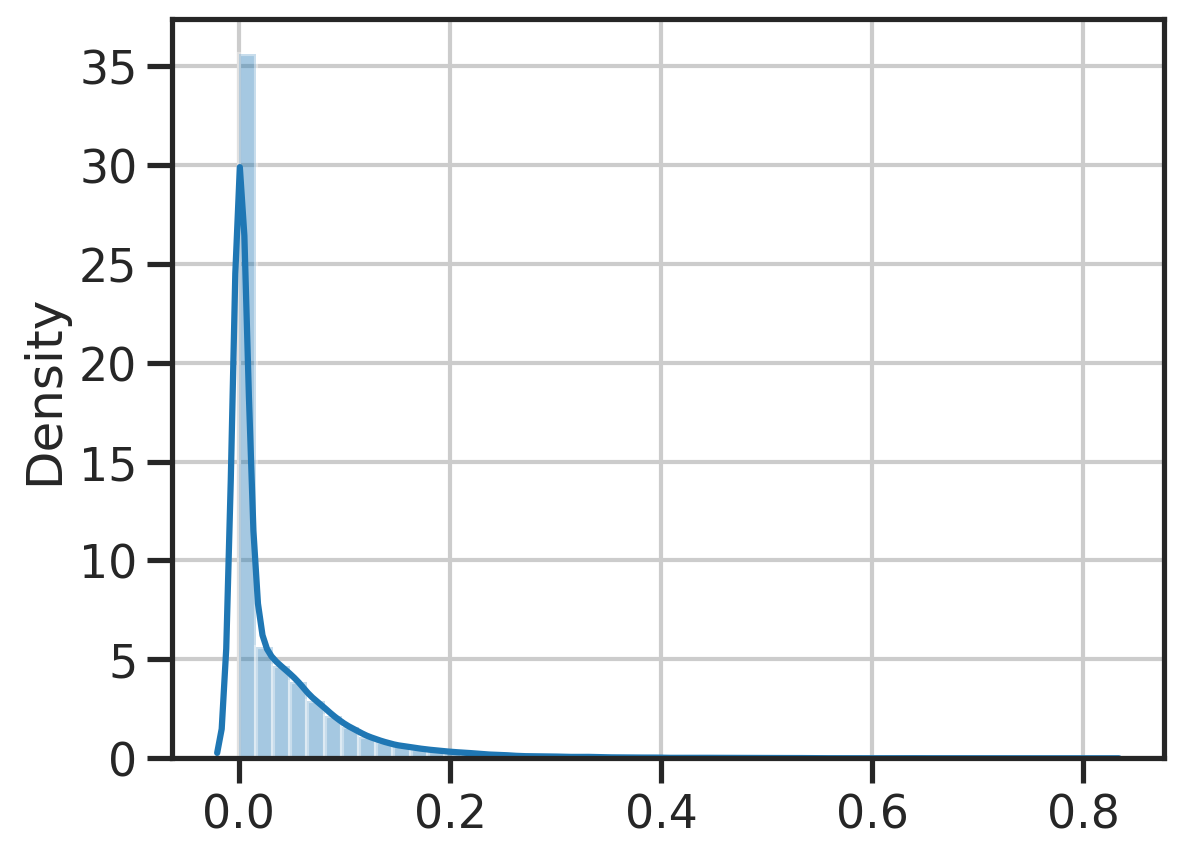

In [7]:
gstd = np.std(pb1t, axis=0)
sns.distplot(gstd)

In [8]:
ts = [8,14,17,21,28,38]

pb1tsub = pb1t[:,gstd>0.4]
pb1tsub_logfc = pb1tsub - np.mean(pb1tsub, axis=0)

rowidx = basicu.order_by_hc(pb1tsub.T)
colidx = basicu.order_by_hc(pb1tsub)

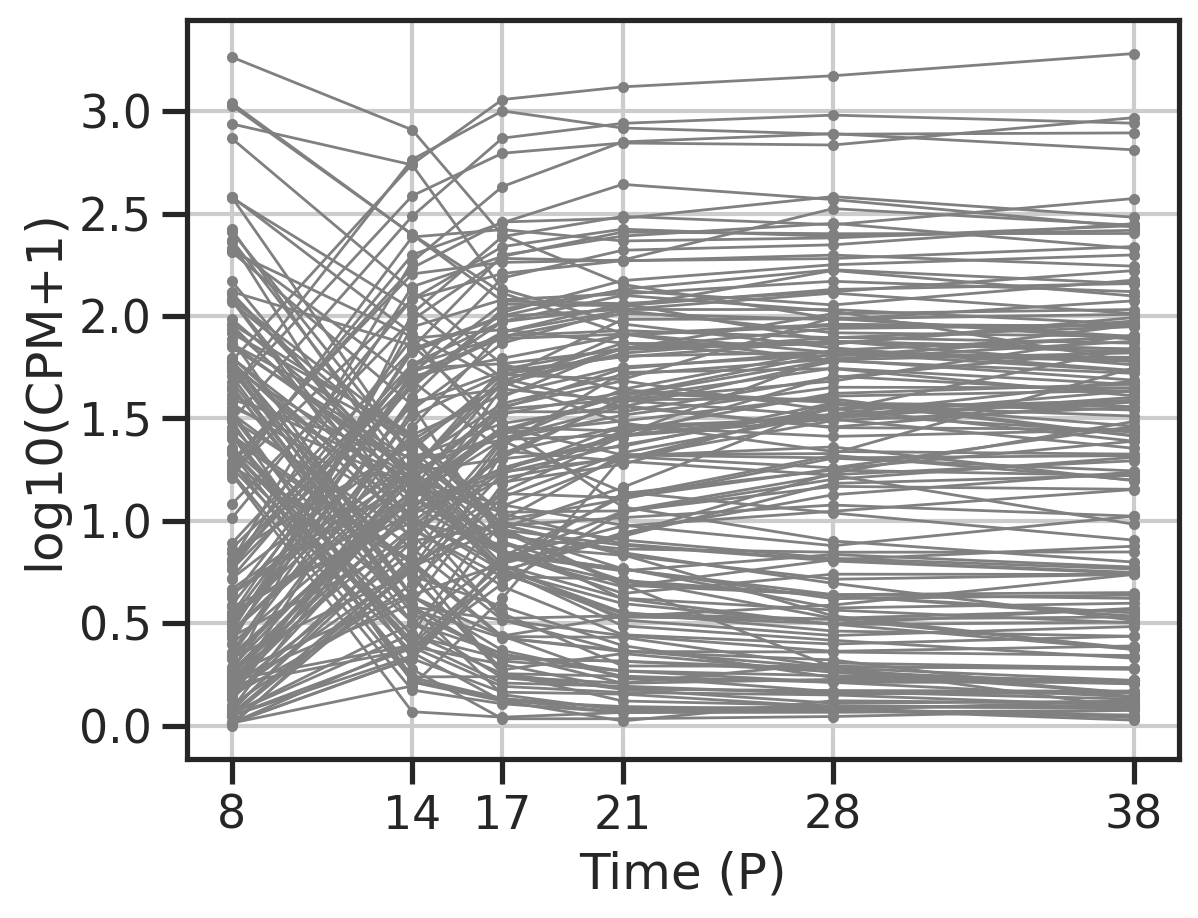

In [9]:
fig, ax = plt.subplots()
for i in range(pb1tsub.shape[1]):
    ax.plot(ts, pb1tsub[:,i], '-o', color='gray', markersize=3, linewidth=1)
ax.set_xticks(ts)
ax.set_ylabel("log10(CPM+1)")
ax.set_xlabel("Time (P)")
plt.show()

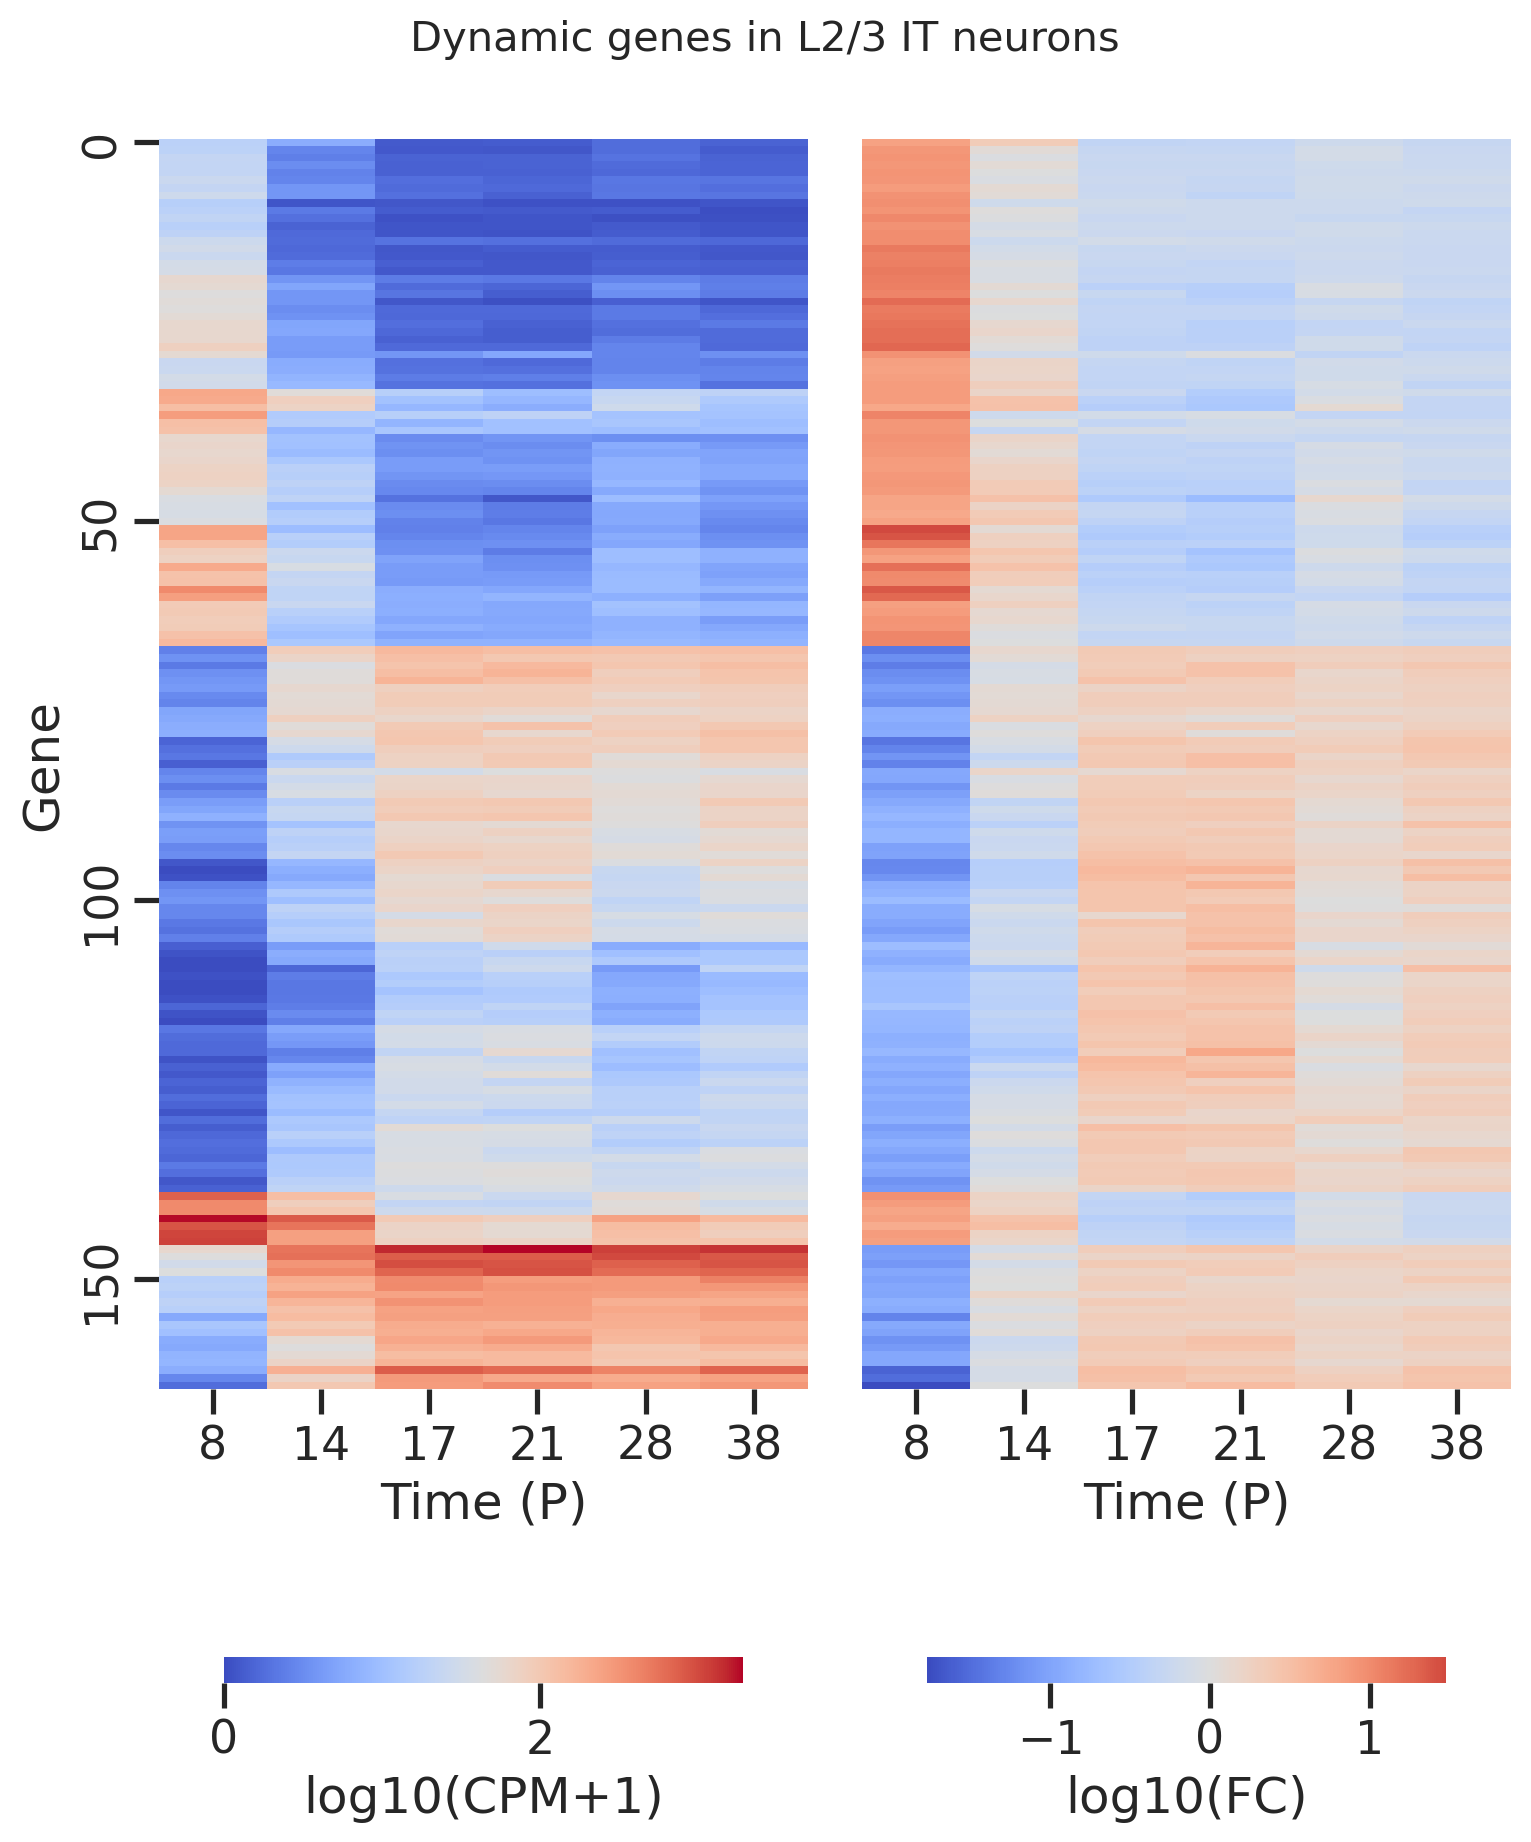

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(2*4,10))
fig.suptitle('Dynamic genes in L2/3 IT neurons', fontsize=15)

ax = axs[0]
sns.heatmap(pb1tsub.T[rowidx][:,colidx], 
            yticklabels=50,
            xticklabels=ts,
            cmap='coolwarm', 
            cbar_kws=dict(location='bottom', shrink=0.8, label='log10(CPM+1)'),
            ax=ax,
           )
ax.set_xlabel('Time (P)')
ax.set_ylabel('Gene')

ax = axs[1]
sns.heatmap(pb1tsub_logfc.T[rowidx][:,colidx], 
            yticklabels=False,
            xticklabels=ts,
            cmap='coolwarm', 
            cbar_kws=dict(location='bottom', shrink=0.8, label='log10(FC)'),
            center=0,
            ax=ax,
           )
ax.set_xlabel('Time (P)')
# ax.set_ylabel('Gene')

fig.tight_layout()
plt.show()

# all cell types

In [11]:
# gstd_all = []
# for i, clst in enumerate(xclsts):
#     pb1t = pbulks[:,i,:]
#     gstd = np.std(pb1t, axis=0)
#     gstd_all.append(gstd)
#     print(clst, pb1t.shape, np.sum(gstd>0.4))
# gstd_all = np.array(gstd_all)

gstd_all = np.std(pbulks, axis=0)
gstd_all.shape

(20, 53801)

In [12]:
g_hits = np.sum(gstd_all > 0.4, axis=0)

In [13]:
t_hits = np.sum(gstd_all > 0.4, axis=1)

In [14]:
g_hits.shape, (g_hits >= 1).sum(), (g_hits == 1).sum(), np.max(g_hits)

((53801,), 2936, 2359, 19)

In [15]:
t_hits.shape, (t_hits >= 1).sum(), (t_hits == 1).sum(), np.max(t_hits)

((20,), 20, 0, 1385)

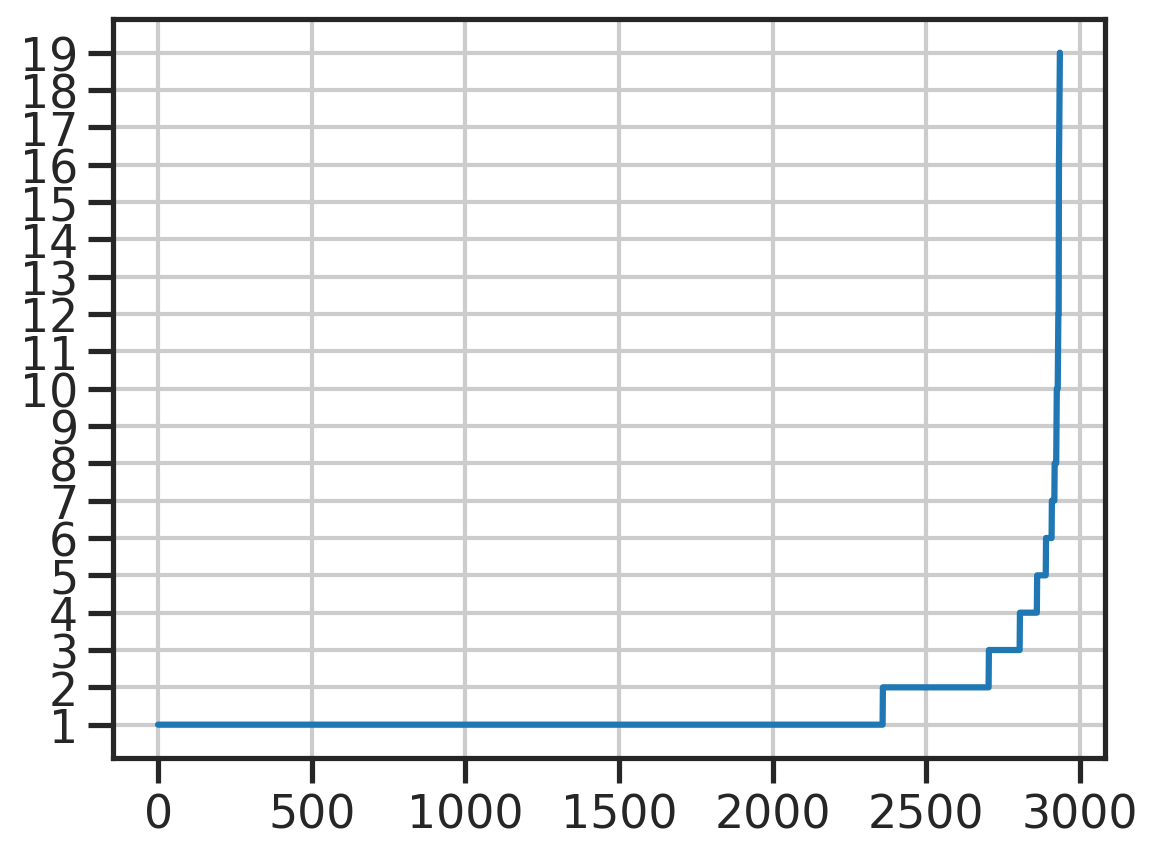

In [16]:
plt.plot(np.sort(g_hits[g_hits>0]))
plt.yticks(np.arange(1,19+1))
plt.show()